In [1]:
import pandas as pd
import numpy as np
import pickle
pd.set_option('display.max_columns', 350)
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import shap
 
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statistics import mean, stdev
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest, chi2, RFE
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import TimeSeriesSplit
 
import imblearn
import xgboost as xgb 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier 
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler  
  
from sklearn.compose import ColumnTransformer  
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb 
import functools 
from sklearn.model_selection import LeaveOneOut, cross_validate, KFold, GridSearchCV, RandomizedSearchCV,cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
  
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, classification_report, roc_auc_score, make_scorer, precision_score, recall_score, roc_auc_score
from sklearn.metrics import fbeta_score, make_scorer, recall_score, log_loss, confusion_matrix, precision_recall_curve, auc,accuracy_score, precision_score,  roc_curve
from sklearn.metrics import average_precision_score,precision_recall_curve, auc,  accuracy_score    
from sklearn.model_selection import train_test_split       
from sklearn.metrics import make_scorer 
from tabulate import tabulate
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

In [2]:
#MT6_teliko_balanced3_1.25

In [3]:
q = pd.read_pickle("FinTech3_2000_3_balanced.pkl")
#FinTech3_balanced125.pkl

In [4]:
# Sorting by timestamp
qual = q.sort_values(by='IDacc')

In [5]:
# Separate the features and target variable
X = qual.drop(['Target'], axis=1) #'IDcus', 'IDacc' 
y = qual['Target']

In [6]:
print(X.columns)

Index(['IDacc', 'SNAPNUMacc', 'MEAS_ACCH_ORIGINATOR',
       'MEAS_ACCL_STRAY_PAYMENT_AMT', 'MEAS_ACCL_APLL_IS_NEW',
       'MEAS_ACCL_APLL_FORBORNE', 'MEAS_ACCL_APPL_TYPE',
       'MEAS_ACCL_PAID_IN_FULL_CM', 'MEAS_ACCL_APPLICATION_SUCCESSFUL',
       'MEAS_ACCL_UNDERWRITING_SEGMENT',
       ...
       'months_since_2000_MEAS_ACCL_PHONE_RPC_DATE_FIRST',
       'months_since_2000_MEAS_ACCL_PHONE_RPC_DATE_LATEST',
       'months_since_2000_MEAS_CUSL_MIN_COMMUNICATION_DATE_3M',
       'months_since_2000_MEAS_CUSL_ADMINISTRATION_STATUS_DATE',
       'months_since_2000_MEAS_CUSL_PRIORITY_CUSTOMER_STATUS_DATE',
       'months_since_2000_MEAS_CUSL_LAST_PAYMENT_DATE',
       'months_since_2000_MEAS_CUSL_LAST_DEFAULT_DATE',
       'months_since_2000_MEAS_CUSL_FIRST_DEFAULT_DATE',
       'months_since_2000_MEAS_CUSH_BIRTHDATE',
       'months_since_2000_MEAS_CUSH_DATE_NOMINAL'],
      dtype='object', length=249)


In [7]:
duplicate_columns = X.columns[X.columns.duplicated()]
print("Duplicate Columns:", duplicate_columns)


Duplicate Columns: Index([], dtype='object')


In [8]:
print("DataFrame Info:")
print(X.info())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 10612 entries, 6772 to 3476
Columns: 249 entries, IDacc to months_since_2000_MEAS_CUSH_DATE_NOMINAL
dtypes: float64(105), int32(25), int64(41), object(78)
memory usage: 19.2+ MB
None


In [9]:
# calculate percentage of each class of target variable
class_ratio = y.value_counts(normalize=True) * 100
class_ratio

Target
1    50.0
0    50.0
Name: proportion, dtype: float64

In [10]:
#Count classes 
"Class distribution:", Counter(y)

('Class distribution:', Counter({1: 5306, 0: 5306}))

In [11]:
#Encoding
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

# One-hot encode categorical features using get_dummies
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True, prefix_sep='_')#drop_first=False

# Concatenate numerical and one-hot encoded categorical columns
X_combined = pd.concat([X[numerical_columns], X_encoded], axis=1)


In [12]:
X_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10612 entries, 6772 to 3476
Columns: 2192 entries, IDacc to MEAS_CUSL_HAS_CONTACT_ATTEMPT_Yes
dtypes: bool(1875), float64(210), int32(25), int64(82)
memory usage: 43.7 MB


In [13]:
# reset index
X_combined.sort_index(inplace=True)
X = X_combined.copy()
X.head()


,IDacc,SNAPNUMacc,MEAS_ACCH_ORIGINATOR,MEAS_ACCL_STRAY_PAYMENT_AMT,MEAS_ACCL_APLL_FORBORNE,MEAS_ACCL_PROMISE_ACCOUNTS,MEAS_ACCL_PROMISE_ACCOUNT,MEAS_ACCL_KEPT_ACCOUNT,MEAS_ACCL_KEPT_PROMISE,MEAS_ACCL_NUM_OF_PROMISES,MEAS_ACCL_HAS_ARRANGEMENT_FLAG,MEAS_ACCL_BROKEN_SETTLEMENT_INDICATOR_CP,MEAS_ACCL_NBR_OF_PROMISES,MEAS_ACCL_NBR_OF_UNKEPT_PROMISES,MEAS_ACCL_STATUS_PRIORITY,MEAS_ACCL_BUCKET_MAX_NBG,MEAS_ACCL_BILLING_DAY,MEAS_ACCT_BRANCH,MEAS_ACCH_ACTIVE,MEAS_ACCH_DELDAYS,MEAS_ACCH_QC_ISCASE,MEAS_ACCH_QC_ISCONTRACT,MEAS_ACCH_COUNT_RESCHEDULINGS,MEAS_ACCH_FLAG_LITIGATION,MEAS_ACCL_SECONDARY_FLOW_FLAG,MEAS_ACCH_FLAG_COSIGNER,MEAS_ACCH_FLAG_GUARANTOR,MEAS_ACCL_NUMBER_OF_COLLATERALS,MEAS_ACCL_PAYMENT_IN_ALLOCATION,MEAS_ACCH_FLAG_SECURED,MEAS_ACCT_CUST_CODE,MEAS_ACCL_INDICATION_CONTACT_ANY_CP,MEAS_ACCL_INDICATION_CONTACT_ATTEMPT_CP,MEAS_ACCL_INDICATION_CONTACT_RIGHTPERSON_CP,MEAS_ACCL_ALLOCATION_CODE,MEAS_PROD_CODE,MEAS_ACCH_SNAPNUM,MEAS_SPRD_CODE,MEAS_ACCL_CONTACT_NUM_ATTEMPTS_CP,MEAS_ACCL_CONTACT_NUM_RPC_CP,MEAS_ACCL_EBA_FORBORNE,MEAS_ACCL_NUMBER_OF_GUARANTORS,MEAS_ACCL_ACTUAL_CONTACTS,MEAS_ACCL_ACTUAL_CONTACTS_PM,MEAS_ACCL_PAYMENT_RECONCILIATION_CODE,MEAS_ACCL_FLAG_OPEN_RECENTLY,MEAS_ACCL_PHONE_RPC_COUNT_EVER,MEAS_ACCL_EED_PERCENT,MEAS_ACCL_PAYMENTS_REPAYMENT_PLAN_CP,MEAS_ACCL_PAYMENTS_ONEOFF_YTD,MEAS_ACCL_PAYMENTS_REPAYMENT_PLAN_YTD,MEAS_ACCL_PAYMENTS_NO_SETTLEMENT_YTD,MEAS_ACCL_AMT_PROMISE,MEAS_ACCL_AMT_KEPT,MEAS_ACCL_ARRANGEMENT_PRINCIPAL,MEAS_ACCL_ARRANGEMENT_BALANCE,MEAS_ACCL_AMT_INSTAL_NOT_MATURED_CM,MEAS_ACCL_APPL_AMT_APPROVED,MEAS_ACCL_APPL_AMT_DUNNING,MEAS_ACCL_APPL_AMT_APPROVED_NEW,MEAS_ACCL_APPL_AMT_FALLOFF,MEAS_ACCL_LMEM_PAYMENTS_CP,MEAS_ACCL_LMEM_PAYMENTS_CUMUL,MEAS_ACCL_AMT_PAYMENTS_TOTAL,MEAS_ACCL_AMT_OVERPAYMENT_ADDITIONAL,MEAS_ACCL_AMT_PAYMENT_YTD,MEAS_ACCH_AMT_PASTDUE,MEAS_ACCL_AMT_DENOUNCED,MEAS_ACCL_AMT_DUE_NBG,MEAS_ACCL_AMT_PAYMENT_REMAINING,MEAS_ACCH_AMT_BAL_ACCOUNTING,MEAS_ACCL_AMT_ORIG_EXPENSES,MEAS_ACCL_AMT_ORIG_INTEREST_OFFBALANCE,MEAS_ACCL_AMT_ORIG_INTEREST_ONBALANCE,MEAS_ACCL_AMT_ORIG_PRINCIPAL,MEAS_ACCL_AMT_ORIG_CLAIM_PNI,MEAS_ACCL_AMT_OVERPAYMENT,MEAS_ACCH_AMT_EXPENSES,MEAS_ACCL_AMT_INTEREST_OFFBALANCE,MEAS_ACCL_AMT_INTEREST_ONBALANCE,MEAS_ACCH_AMT_PRINCIPAL,MEAS_ACCL_AMT_CLAIM_PNI,MEAS_ACCL_AMT_CLAIM_G3,MEAS_ACCL_DUE_PRINCIPAL,MEAS_ACCL_AMT_CLAIM_G4,MEAS_ACCL_AMT_PRINCIPAL_TOTAL,MEAS_ACCL_AMT_GBV,MEAS_ACCH_AMT_LIMIT,MEAS_ACCL_DEFAULT_BALANCE,MEAS_ACCH_AMT_ARREARS,MEAS_ACCL_LATE_INTEREST,MEAS_ACCL_INTEREST,MEAS_ACCH_AMT_MINPAYMENT,MEAS_ACCH_AMT_BALANCE,MEAS_ACCL_PURCHASE_BALANCE,MEAS_ACCH_AMT_WRITEOFF,MEAS_ACCH_AMT_PAYMENT_LAST,MEAS_ACCL_COLLATERALS_VALUE,MEAS_ACCL_COLLA_MARKET_VALUE,MEAS_ACCL_AMT_BAL_ACCOUNTING_RR,MEAS_ACCL_COLLATERAL_OR_RE_MARKET_VALUE,MEAS_ACCL_EED_GUARANTEED_AMOUNT,IDcus,SNAPNUMcus,MEAS_CUSL_PHONE_RPC_COUNT,MEAS_CUSL_COUNT_RPC,MEAS_CUSL_COUNT_NO_CONTACT,MEAS_CUSL_COUNT_3RD_PARTY,MEAS_CUSL_DIALLER_ATTEMPTS_COUNT,MEAS_CUSL_HAS_ACTIVE_ARRANGEMENT,MEAS_CUSL_HAS_PAYMENT,MEAS_CUSH_COUNT_PHONES,MEAS_CUSL_COLLECTION_CASES_NUM,MEAS_CUSL_HAS_RESTRUCTURING_APPLICATION,MEAS_CUSH_OWNER_HOME,MEAS_CUSL_IS_CO_OWNER,MEAS_CUSL_IS_GUARANTOR,MEAS_CUSL_IS_PRIMARY_OWNER,MEAS_CUSL_COLLECTION_CASES_NUM_PRIMARY_OWNER,MEAS_CUSL_TOTAL_ACCOUNTS,MEAS_CUSL_LAST_PAYMENT_AMOUNT,MEAS_CUSL_DEBT_AMOUNT_PRIMARY_OWNER,MEAS_CUSL_TOTAL_OUTSTANDING_AMOUNT,MEAS_CUSL_DEBT_AMOUNT,MEAS_CUSL_ACCOUNTING_BALANCE,MEAS_CUSL_BALANCE,MEAS_CUSL_BALANCE_PRIMARY_OWNER,months_since_2000_MEAS_ACCL_LAST_KEPT_BROKEN_DATE,months_since_2000_MEAS_ACCL_PREVIOUS_RETURN_DATE,months_since_2000_MEAS_ACCH_DATE_EXP,months_since_2000_MEAS_ACCL_LAST_BILLING_DATE_CLIENT,months_since_2000_MEAS_ACCH_DATE_BILLING_NEXT,months_since_2000_MEAS_ACCH_DATE_LITIGATION,months_since_2000_MEAS_ACCH_DATE_PAYMENT_LAST,months_since_2000_MEAS_ACCH_DELINQ_PACKAGE_DATE,months_since_2000_MEAS_ACCL_PACKET_DEFINITION_DATE,months_since_2000_MEAS_ACCL_LAST_RECALL_DATE,months_since_2000_MEAS_ACCH_DELINQ_STRATEGY_ENTRYDATE,months_since_2000_MEAS_ACCH_DELINQ_STEP_ENTRYDATE,months

In [14]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [15]:
# Correlation Analysis
correlation_matrix = X_train.corr()
threshold = 0.9
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

In [16]:
X_train = X_train.drop(highly_correlated_features, axis=1)
X_test = X_test.drop(highly_correlated_features, axis=1)

In [17]:
# Use MinMaxScaler instead of RobustScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
k_best = 350 
select_k_best = SelectKBest(chi2, k=k_best)
X_train_scaled = select_k_best.fit_transform(X_train_scaled, y_train)
X_test_scaled = select_k_best.transform(X_test_scaled)

In [19]:
# Get the indices of the selected features
selected_feature_indices_k_best = select_k_best.get_support(indices=True)

# Get the column names based on the selected indices
selected_column_names_k_best = X.columns[selected_feature_indices_k_best]
print("Selected Column Names after SelectKBest:", selected_column_names_k_best.tolist())

Selected Column Names after SelectKBest: ['MEAS_ACCL_PAYMENTS_REPAYMENT_PLAN_YTD', 'MEAS_ACCH_AMT_BAL_ACCOUNTING', 'MEAS_ACCL_AMT_ORIG_INTEREST_OFFBALANCE', 'MEAS_ACCL_AMT_ORIG_INTEREST_ONBALANCE', 'MEAS_ACCL_AMT_ORIG_PRINCIPAL', 'MEAS_ACCH_AMT_EXPENSES', 'MEAS_ACCL_AMT_CLAIM_PNI', 'MEAS_ACCL_DUE_PRINCIPAL', 'MEAS_ACCL_AMT_PRINCIPAL_TOTAL', 'MEAS_ACCH_AMT_LIMIT', 'MEAS_ACCH_AMT_BALANCE', 'MEAS_ACCH_AMT_WRITEOFF', 'MEAS_ACCL_AMT_BAL_ACCOUNTING_RR', 'MEAS_ACCL_COLLATERAL_OR_RE_MARKET_VALUE', 'MEAS_CUSL_COUNT_3RD_PARTY', 'MEAS_CUSL_COLLECTION_CASES_NUM', 'MEAS_CUSL_BALANCE', 'months_since_2000_MEAS_ACCL_LAST_KEPT_BROKEN_DATE', 'months_since_2000_MEAS_ACCL_LAST_RECALL_DATE', 'months_since_2000_MEAS_ACCH_DELINQ_STRATEGY_ENTRYDATE', 'months_since_2000_MEAS_CUSL_LAST_DEFAULT_DATE', 'IDacc', 'MEAS_ACCL_APLL_FORBORNE', 'MEAS_ACCL_PROMISE_ACCOUNTS', 'MEAS_ACCL_KEPT_PROMISE', 'MEAS_ACCL_NUM_OF_PROMISES', 'MEAS_ACCL_HAS_ARRANGEMENT_FLAG', 'MEAS_ACCL_NBR_OF_UNKEPT_PROMISES', 'MEAS_ACCL_STATUS_PRIOR

In [20]:
# To check the shape of the array
print("Shape:", X_train_scaled.shape)

# To check the data type of the elements in the array
print("Data type:", X_train_scaled.dtype)


Shape: (8489, 350)
Data type: float64


In [21]:
from prettytable import PrettyTable
# Create a table
table = PrettyTable()
#model_labels = ["Random Forest", "XGBoost", 'Grid Search]
table.field_names = ["Model", "ROC-AUC", "Precision-Recall AUC"] 

Random Forest

In [22]:
# fit Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

# Predict probabilities on the test set
y_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]


# Evaluate ROC-AUC
roc_auc_rf = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC: {roc_auc_rf:.4f}')

#Precision-Recall AUC
pr_auc_rf = average_precision_score(y_test, y_pred_proba)
print(f'Precision-Recall AUC: {pr_auc_rf:.4f}')
table.add_row(["RandomForest", f"{roc_auc_rf:.4f}", f"{pr_auc_rf:.4f}"])

# Classification Report
y_pred = rf.predict(X_test_scaled)
class_report = classification_report(y_test, y_pred)
print(class_report)

ROC-AUC: 0.4966
Precision-Recall AUC: 0.5086
              precision    recall  f1-score   support

           0       0.49      0.41      0.44       531
           1       0.49      0.57      0.53       530

    accuracy                           0.49      1061
   macro avg       0.49      0.49      0.49      1061
weighted avg       0.49      0.49      0.49      1061



SVM

In [23]:
# Fit SVM
svm = SVC(probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)

# Predict probabilities on the test set
y_pred_proba_svm = svm.predict_proba(X_test_scaled)[:, 1]

# Evaluate ROC-AUC
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)
print(f'ROC-AUC (SVM): {roc_auc_svm:.4f}')

# Precision-Recall AUC
pr_auc_svm = average_precision_score(y_test, y_pred_proba_svm)
print(f'Precision-Recall AUC (SVM): {pr_auc_svm:.4f}')

table.add_row(["SVM", f"{roc_auc_svm:.4f}", f"{pr_auc_svm:.4f}"])

# Classification Report
y_pred_svm = svm.predict(X_test_scaled)
class_report_svm = classification_report(y_test, y_pred_svm)
print(class_report_svm)


ROC-AUC (SVM): 0.5054
Precision-Recall AUC (SVM): 0.5147
              precision    recall  f1-score   support

           0       0.51      0.45      0.48       531
           1       0.51      0.57      0.54       530

    accuracy                           0.51      1061
   macro avg       0.51      0.51      0.51      1061
weighted avg       0.51      0.51      0.51      1061



Logistic Regression

In [24]:
# Fit Logistic Regression
lr = LogisticRegression(random_state=42)
lr.fit(X_train_scaled, y_train)

# Predict probabilities on the test set
y_pred_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

# Evaluate ROC-AUC
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f'ROC-AUC (Logistic Regression): {roc_auc_lr:.4f}')

# Precision-Recall AUC
pr_auc_lr = average_precision_score(y_test, y_pred_proba_lr)
print(f'Precision-Recall AUC (Logistic Regression): {pr_auc_lr:.4f}')

table.add_row(["LogisticRegression", f"{roc_auc_lr:.4f}", f"{pr_auc_lr:.4f}"])

# Classification Report
y_pred_lr = lr.predict(X_test_scaled)
class_report_lr = classification_report(y_test, y_pred_lr)
print(class_report_lr)


ROC-AUC (Logistic Regression): 0.4911
Precision-Recall AUC (Logistic Regression): 0.5153
              precision    recall  f1-score   support

           0       0.48      0.48      0.48       531
           1       0.48      0.49      0.48       530

    accuracy                           0.48      1061
   macro avg       0.48      0.48      0.48      1061
weighted avg       0.48      0.48      0.48      1061



AdaBoost

In [25]:
# Fit AdaBoost
adaboost = AdaBoostClassifier(random_state=42)
adaboost.fit(X_train_scaled, y_train)

# Predict probabilities on the test set
y_pred_proba_adaboost = adaboost.predict_proba(X_test_scaled)[:, 1]

# Evaluate ROC-AUC
roc_auc_adaboost = roc_auc_score(y_test, y_pred_proba_adaboost)
print(f'ROC-AUC (AdaBoost): {roc_auc_adaboost:.4f}')

# Precision-Recall AUC
pr_auc_adaboost = average_precision_score(y_test, y_pred_proba_adaboost)
print(f'Precision-Recall AUC (AdaBoost): {pr_auc_adaboost:.4f}')

table.add_row(["AdaBoost", f"{roc_auc_adaboost:.4f}", f"{pr_auc_adaboost:.4f}"])

# Classification Report
y_pred_adaboost = adaboost.predict(X_test_scaled)
class_report_adaboost = classification_report(y_test, y_pred_adaboost)
print(class_report_adaboost)


ROC-AUC (AdaBoost): 0.4906
Precision-Recall AUC (AdaBoost): 0.5000
              precision    recall  f1-score   support

           0       0.50      0.79      0.61       531
           1       0.48      0.19      0.28       530

    accuracy                           0.49      1061
   macro avg       0.49      0.49      0.44      1061
weighted avg       0.49      0.49      0.44      1061



XGBoost

In [26]:
# XGBoost
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_scaled, y_train)

# Predict probabilities on the test set
y_pred_proba = xgb.predict_proba(X_test_scaled)[:, 1]

# Evaluate ROC-AUC
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC: {roc_auc_xgb:.4f}') 

#Precision-Recall AUC
pr_auc_xgb = average_precision_score(y_test, y_pred_proba)
print(f'Precision-Recall AUC: {pr_auc_xgb:.4f}')
table.add_row(["XGBoost", f"{roc_auc_xgb:.4f}", f"{pr_auc_xgb:.4f}"])

# Classification Report
y_pred = xgb.predict(X_test_scaled)
class_report = classification_report(y_test, y_pred) 
print(class_report)

ROC-AUC: 0.4853
Precision-Recall AUC: 0.5061
              precision    recall  f1-score   support

           0       0.49      0.53      0.51       531
           1       0.49      0.45      0.47       530

    accuracy                           0.49      1061
   macro avg       0.49      0.49      0.49      1061
weighted avg       0.49      0.49      0.49      1061



In [27]:
print (table)

+--------------------+---------+----------------------+
|       Model        | ROC-AUC | Precision-Recall AUC |
+--------------------+---------+----------------------+
|    RandomForest    |  0.4966 |        0.5086        |
|        SVM         |  0.5054 |        0.5147        |
| LogisticRegression |  0.4911 |        0.5153        |
|      AdaBoost      |  0.4906 |        0.5000        |
|      XGBoost       |  0.4853 |        0.5061        |
+--------------------+---------+----------------------+


In [28]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Perform grid search with precision-recall AUC as the scoring metric
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='average_precision', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Get the best estimator
best_rf = grid_search.best_estimator_

# Predict probabilities and classes on the test set
y_pred_proba = best_rf.predict_proba(X_test_scaled)[:, 1]
y_pred = best_rf.predict(X_test_scaled)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


In [29]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.43      0.46       531
           1       0.49      0.55      0.52       530

    accuracy                           0.49      1061
   macro avg       0.49      0.49      0.49      1061
weighted avg       0.49      0.49      0.49      1061



In [30]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)



Confusion Matrix:
[[226 305]
 [236 294]]


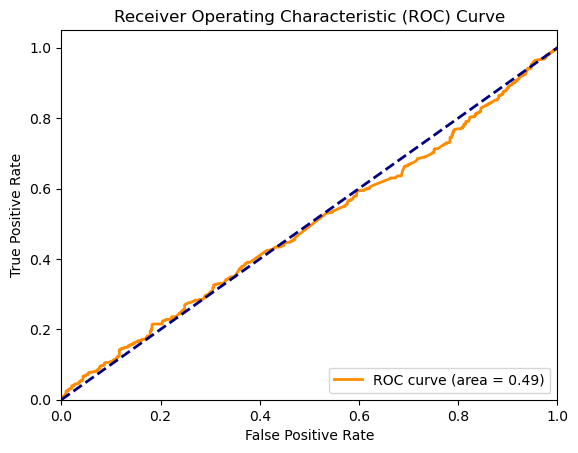

In [31]:
# ROC AUC Plot
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


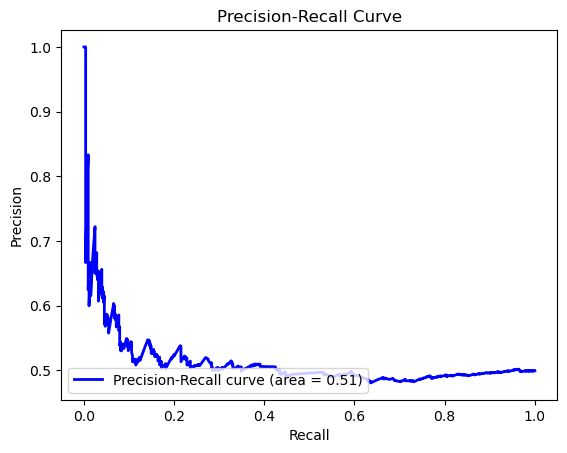

In [32]:
# Precision-Recall AUC Plot
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
